<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_finetune_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install emoji library
!pip install emot

     |████████████████████████████████| 61 kB 17 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Please install GPU version of TF
True
2.8.0
2.8.0


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load software data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


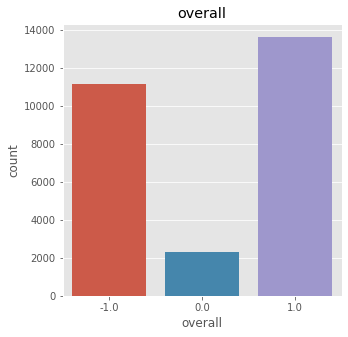

In [ ]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


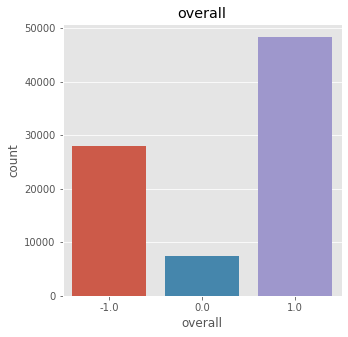

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


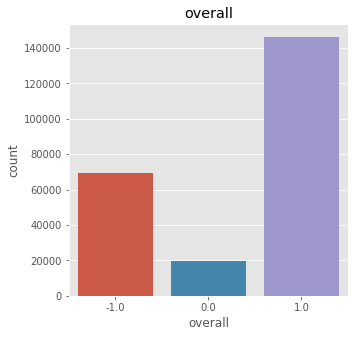

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


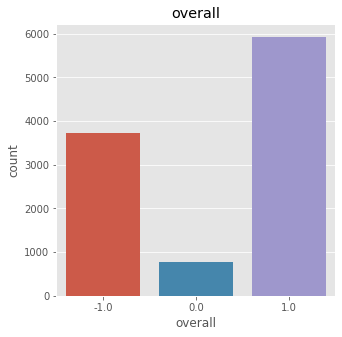

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5900 positive，3700 negative，770 neutral

80%(8056) training and 20%(2314) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4480,:]
  train_neudata = neu.iloc[:616,:]
  train_negdata = neg.iloc[:2960,:]

  # split to get test for each class
  test_posdata = pos.iloc[4480:5900,:]
  test_neudata = neu.iloc[616:770,:]
  test_negdata = neg.iloc[2960:3700,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1998 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df4_train.head()

,overall,reviewTime,reviewText
471,2.0,2018,I'm afraid I've made a big mistake. Although I...
8330,2.0,2018,After YEARS of paying the high price of indivi...
9402,1.0,2018,As Described and top quality
4707,2.0,2018,Do not use!!! I bought this to use on a brand...
1505,2.0,2018,I have paid for this item and I can not downlo...


## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
3267,1.0,2002,I got XP on a new laptop. Having previously us...,got emoji tongue sticking cheeky playful blowi...
4369,1.0,2002,Everyone's fussing so much about Word versus W...,everyones fussing much word versus writer ones...
18679,1.0,2001,I was given this game last year for Christmas ...,given game last christmas official addict prev...
20120,2.0,2002,I am fairly disappointed with Ulead's DVD Movi...,fairly disappointed uleads dvd moviefactory gl...
14938,2.0,2006,"In earlier version of Ghost, you could create ...",earlier version ghost create bootable floppy r...


In [ ]:
df1_test.head()

,overall,reviewTime,reviewText,cleanText
10586,1.0,2005,"I use NIS 2005 to protect my PC, and I am a sa...",use nis protect pc satisfied customer however ...
21410,1.0,2003,So far so good. Keeps my pc very secure with ...,far good keeps pc secure latest updates dont b...
16328,2.0,2006,Do NOT waste your money on this piece of junk ...,waste money piece junk software used studio ye...
8404,2.0,2006,This is all a scam for the maker to get your c...,scam maker get credit card info steal happened...
25833,1.0,2006,If you're a Baby Boomer a Senior or just spend...,youre baby boomer senior spend lot time onine ...


## Text Tokenization

In [ ]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

30241 words are used
Training:
Average length of each row >> 70.25819265143993
Maximum length of each row >> 1610


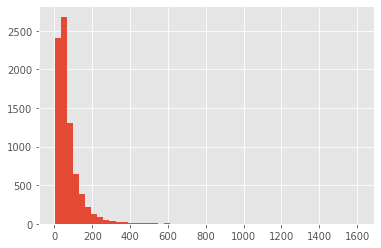

Testing
Average length of each row >> 67.08426966292134
Maximum length of each row >> 1208


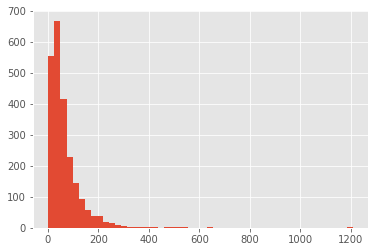

max sequence length:  1610


In [ ]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

23979 words are used
Training:
Average length of each row >> 55.187562065541215
Maximum length of each row >> 1264


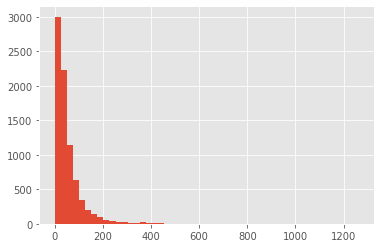

Testing
Average length of each row >> 52.785652549697495
Maximum length of each row >> 989


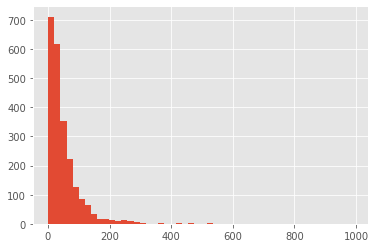

max sequence length:  1264


In [ ]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

14756 words are used
Training:
Average length of each row >> 27.482497517378352
Maximum length of each row >> 665


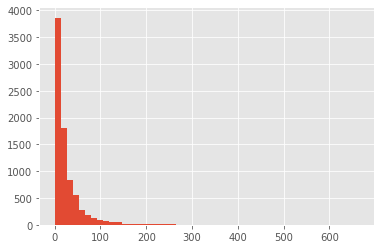

Testing
Average length of each row >> 25.43474503025065
Maximum length of each row >> 578


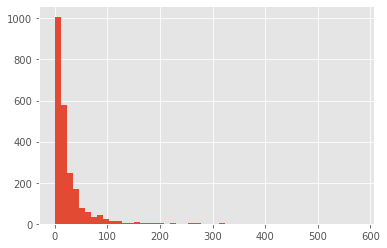

max sequence length:  665


In [ ]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

11658 words are used
Training:
Average length of each row >> 16.8545183714002
Maximum length of each row >> 477


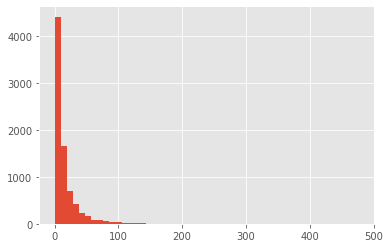

Testing
Average length of each row >> 16.000432152117547
Maximum length of each row >> 447


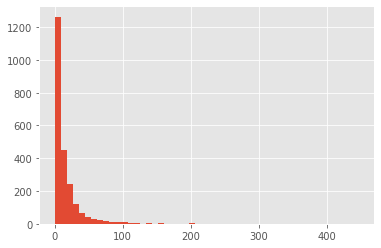

max sequence length:  477


In [ ]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

## Padding

In [ ]:
sequence_size = max(df1_maxlen,df2_maxlen,df3_maxlen,df4_maxlen)
print("max sequence length for software: ",sequence_size)

max sequence length for software:  1610


In [ ]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

In [ ]:
df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

In [ ]:
df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

In [ ]:
df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

## Build LSTM Model and Train on 1998-2006

In [ ]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  30241


In [ ]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [ ]:
lstm = bilstm_model()
plot_model(lstm)
lstm_no_hist = lstm.fit(df1_train_pad,df1_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_test_pad,df1_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1610, 100)         3024100   
                                                                 
 bidirectional (Bidirectiona  (None, 1610, 256)        234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 412160)            0         
                                                                 
 dense (Dense)               (None, 32)                13189152  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

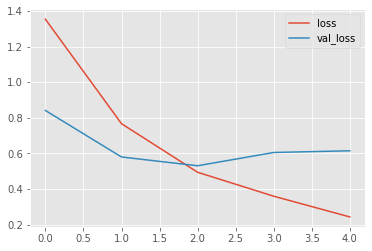

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

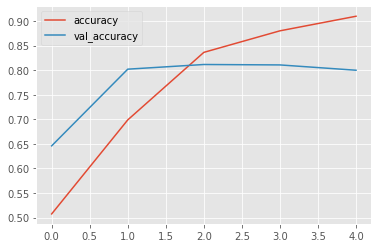

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
lstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM.h5')

## Evaluate on other data

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM.h5')
load_lstm.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 65s 867ms/step - loss: 1.6674 - accuracy: 0.4870


[1.6674236059188843, 0.4870354235172272]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM.h5')
load_lstm.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 68s 921ms/step - loss: 1.2589 - accuracy: 0.5614


[1.258852243423462, 0.5613656044006348]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM.h5')
load_lstm.evaluate(df4_test_pad,df4_test_label)

73/73 [==============================] - 66s 882ms/step - loss: 1.1445 - accuracy: 0.5782


[1.144472599029541, 0.5782195329666138]

## Fine tuned on 2007-2012 data

In [ ]:
plot_model(load_lstm)
lstm_no_hist = load_lstm.fit(df2_train_pad,df2_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_test_pad,df2_test_label),callbacks=[es])

Epoch 1/8
32/32 [==============================] - 789s 24s/step - loss: 0.9724 - accuracy: 0.5679 - val_loss: 0.8075 - val_accuracy: 0.6616
Epoch 2/8
32/32 [==============================] - 765s 24s/step - loss: 0.7834 - accuracy: 0.6805 - val_loss: 0.6908 - val_accuracy: 0.7519
Epoch 3/8
32/32 [==============================] - 737s 23s/step - loss: 0.5880 - accuracy: 0.7993 - val_loss: 0.5771 - val_accuracy: 0.7943
Epoch 4/8
32/32 [==============================] - 759s 24s/step - loss: 0.3574 - accuracy: 0.8781 - val_loss: 0.6166 - val_accuracy: 0.7930
Epoch 5/8
32/32 [==============================] - 765s 24s/step - loss: 0.2210 - accuracy: 0.9229 - val_loss: 0.7219 - val_accuracy: 0.8034
Epoch 5: early stopping


In [ ]:
load_lstm.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_2.h5')

## Evaluate on other data

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_2.h5')
load_lstm_ft_2.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 61s 815ms/step - loss: 1.5306 - accuracy: 0.5795


[1.530570149421692, 0.5795159935951233]

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_2.h5')
load_lstm_ft_2.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 61s 825ms/step - loss: 1.4812 - accuracy: 0.5506


[1.4811806678771973, 0.550561785697937]

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_2.h5')
load_lstm_ft_2.evaluate(df4_test_pad,df4_test_label)

73/73 [==============================] - 60s 807ms/step - loss: 1.3103 - accuracy: 0.5869


[1.3102645874023438, 0.5868625640869141]

## Fine tuned on 2013-2017

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_2.h5')

In [ ]:
plot_model(load_lstm_ft_2)
lstm_no_hist = load_lstm_ft_2.fit(df3_train_pad,df3_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_test_pad,df3_test_label),callbacks=[es])

Epoch 1/8
32/32 [==============================] - 771s 24s/step - loss: 0.9926 - accuracy: 0.5618 - val_loss: 0.8318 - val_accuracy: 0.6690
Epoch 2/8
32/32 [==============================] - 745s 23s/step - loss: 0.7831 - accuracy: 0.6807 - val_loss: 0.7109 - val_accuracy: 0.7602
Epoch 3/8
32/32 [==============================] - 767s 24s/step - loss: 0.6810 - accuracy: 0.7721 - val_loss: 0.5350 - val_accuracy: 0.8042
Epoch 4/8
32/32 [==============================] - 739s 23s/step - loss: 0.4719 - accuracy: 0.8369 - val_loss: 0.5479 - val_accuracy: 0.8081
Epoch 5/8
32/32 [==============================] - 749s 23s/step - loss: 0.3610 - accuracy: 0.8761 - val_loss: 0.6798 - val_accuracy: 0.8047
Epoch 5: early stopping


In [ ]:
load_lstm_ft_2.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_3.h5')

## Evaluate on other data

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_3.h5')
load_lstm_ft_3.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 70s 928ms/step - loss: 3.0371 - accuracy: 0.4209


[3.0371363162994385, 0.4209161698818207]

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_3.h5')
load_lstm_ft_3.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 62s 832ms/step - loss: 2.0933 - accuracy: 0.5540


[2.093336582183838, 0.554019033908844]

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_3.h5')
load_lstm_ft_3.evaluate(df4_test_pad,df4_test_label)

73/73 [==============================] - 62s 814ms/step - loss: 1.2981 - accuracy: 0.5229


[1.2980626821517944, 0.5229040384292603]

## Fine tuned on 2018

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_3.h5')

In [ ]:
plot_model(load_lstm_ft_3)
lstm_no_hist = load_lstm_ft_3.fit(df4_train_pad,df4_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df4_test_pad,df4_test_label),callbacks=[es])

Epoch 1/8
32/32 [==============================] - 781s 24s/step - loss: 1.0587 - accuracy: 0.5472 - val_loss: 0.8118 - val_accuracy: 0.6387
Epoch 2/8
32/32 [==============================] - 749s 23s/step - loss: 0.9537 - accuracy: 0.5582 - val_loss: 0.8278 - val_accuracy: 0.6162
Epoch 3/8
32/32 [==============================] - 760s 24s/step - loss: 0.7566 - accuracy: 0.6758 - val_loss: 0.5910 - val_accuracy: 0.7753
Epoch 4/8
32/32 [==============================] - 734s 23s/step - loss: 0.5681 - accuracy: 0.7877 - val_loss: 0.5318 - val_accuracy: 0.8060
Epoch 5/8
32/32 [==============================] - 747s 23s/step - loss: 0.4590 - accuracy: 0.8353 - val_loss: 0.5290 - val_accuracy: 0.8155
Epoch 6/8
32/32 [==============================] - 749s 23s/step - loss: 0.3682 - accuracy: 0.8648 - val_loss: 0.6646 - val_accuracy: 0.7869
Epoch 6: early stopping


In [ ]:
load_lstm_ft_3.save('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_4.h5')

## Evaluate on other data

In [ ]:
load_lstm_ft_4 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_4.h5')
load_lstm_ft_4.evaluate(df1_test_pad,df1_test_label)

73/73 [==============================] - 64s 867ms/step - loss: 2.8708 - accuracy: 0.3643


[2.8707666397094727, 0.36430424451828003]

In [ ]:
load_lstm_ft_4 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_4.h5')
load_lstm_ft_4.evaluate(df2_test_pad,df2_test_label)

73/73 [==============================] - 74s 892ms/step - loss: 2.6925 - accuracy: 0.3959


[2.692502975463867, 0.39585134387016296]

In [ ]:
load_lstm_ft_4 = load_model('./drive/MyDrive/Colab Notebooks/CL/software/LSTM/BiLSTM_fine_tuned_4.h5')
load_lstm_ft_4.evaluate(df3_test_pad,df3_test_label)

73/73 [==============================] - 62s 838ms/step - loss: 1.6989 - accuracy: 0.5346


[1.698900580406189, 0.534572184085846]